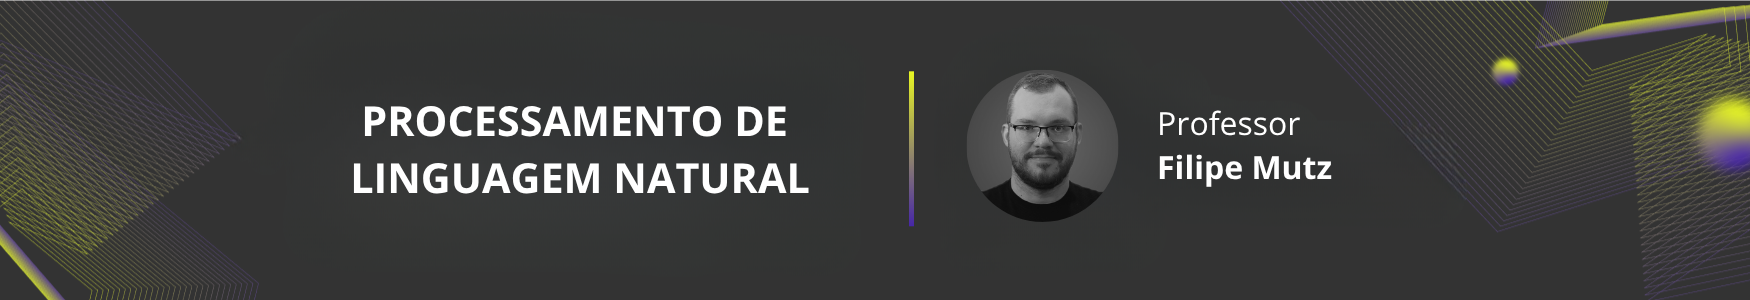

# 📝🤖 Aprendizado baseado em Sequências (*Sequence Learning*), Redes Neurais Recorrentes e Backpropagation Through Time (BPTT)

No primeiro tópico, estudamos o método BoW que utiliza as frequências das palavras para construir representações vetoriais dos documentos. Este método assume que as palavras do documento são independentes e não considera a ordem com que as palavras são utilizadas.

Esta hipótese pode ser problemática em algumas tarefas. Considere as frases abaixo, por exemplo.

- *"O gato perseguiu o rato."*
- *"O rato perseguiu o gato."*

- *"Não gostei do trailer, mas gostei do filme."*
- *"Gostei do trailer, mas não gostei do filme."*

Sem considerar a ordem das palavras, não é possível distinguir qual animal era o caçador nas primeiras duas frases e não é possível julgar se a pessoa gostou do filme nas duas últimas.

Neste notebook, vamos compreender o que é aprendizado baseado em sequências (*Sequence Learning*) e como Redes Neurais Recorrentes (*Recurrent Neural Networks* - RNNs) podem ser utilizadas neste tipo de tarefa. Em RNNs, palavras são usadas uma de cada vez como entrada e o modelo é capaz de "lembrar" informações vistas anteriormente. Além disto, RNNs  possuem inerentemente a idéia de **ordem entre os termos**. Para treinar redes neurais recorrentes é utilizado o algoritmo  *Backpropagation Through Time* (BPTT).

## Agenda

Neste notebook, vamos estudar os seguintes tópicos:

1. O que é aprendizado baseado em sequências (*Sequence Learning*)
2. O que são redes neurais recorrentes.
3. Como redes neurais recorrentes são treinadas usando Backpropagation Through Time (BPTT).


## Aprendizado baseado em Sequências (*Sequence Learning*)

O aprendizado baseado em de sequências (*sequence learning*) é uma área dedicada a dados que possuem uma ordem temporal ou sequencial. O objetivo é identificar padrões, dependências ou relações ao longo da sequência de elementos. Diferentemente de tarefas tradicionais de classificação ou regressão, em que os dados de entrada são tratados como vetores fixos e independentes, no aprendizado de sequências **o modelo leva em consideração a ordem e a dependência entre os elementos** da entrada.


### Classificação

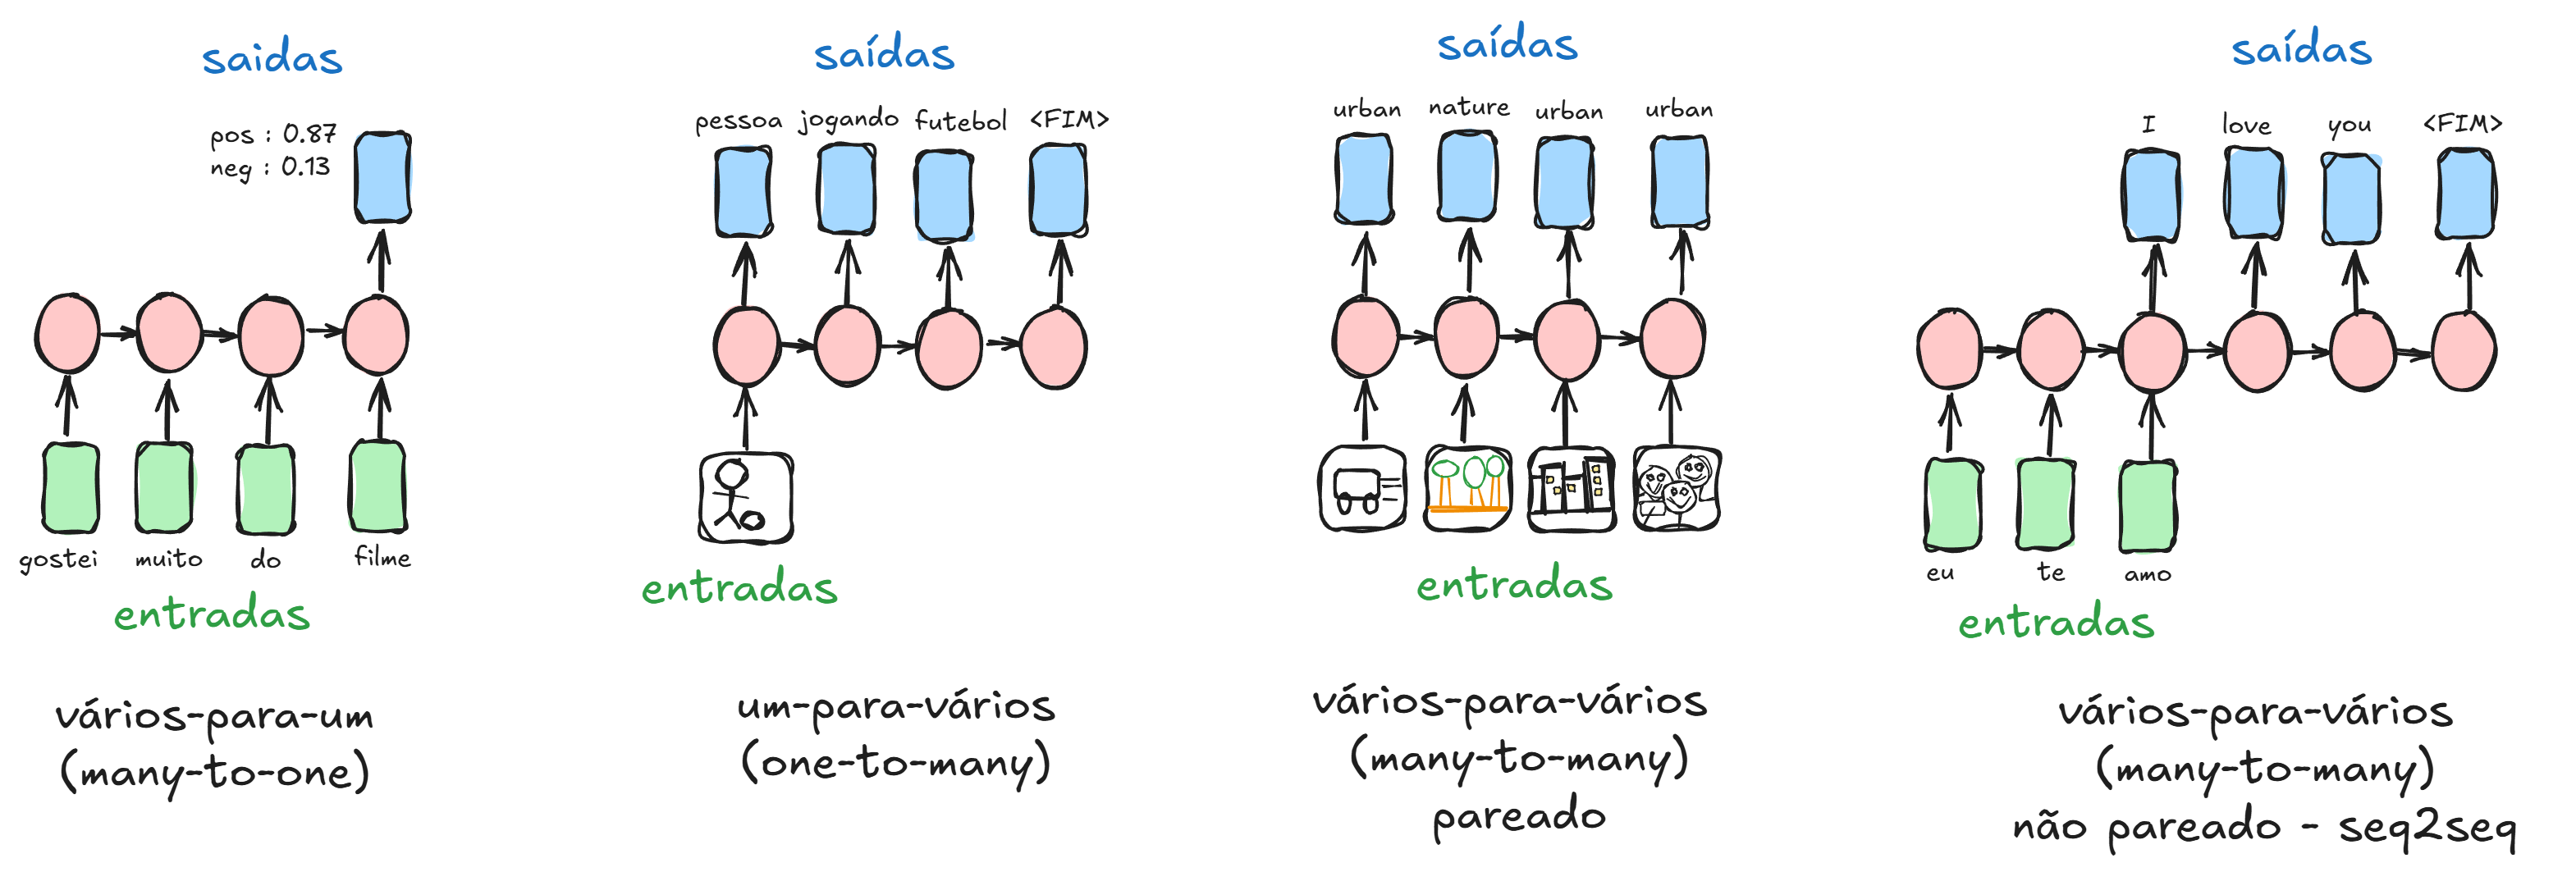


Tarefas de aprendizado de sequências podem ser classificados em:

- **Vários-para-um (many-to-one)**: existem várias entradas para uma saída. Exemplos: classificação de sentimentos, predição do valor futuro de uma ação, etc.
- **Um-para-vários (one-to-many)**: a partir de uma entrada são produzidas várias saídas. Exemplo: Criação de captions para imagens.
- **Vários-para-vários (many-to-many)**: existem várias entradas e várias saídas. Podem ser de dois tipos:
  - **Pareados**: quando existe uma saída para cada entrada. Exemplo: identificação de expressão facial em todos os frames de um vídeo.
  - **Não-pareados (Seq2seq)**: quando o número de saídas e entradas é independente. Exemplo: tradução ou geração de código-fonte.


## Redes Neurais Recorrentes (RNNs)

Redes neurais recorrentes (RNNs) são técnicas para aprendizado baseado em sequências ou aprendizado de sequências (em inglês, *sequence learning*). Redes neurais feedforward (e.g., MLPs ou CNNs) processam dados de forma independente, isto é, cada entrada é processada sem considerar entradas anteriores.

RNNs, por outro lado:

- processam sequências de dados, **um de cada vez**;
- são capazes de "**lembrar**" informações vistas anteriormente; e
- compreendem inerentemente a idéia de **ordem** entre os termos.

Em processamento de linguagem natural, os *embeddings* associados aos tokens de um documento podem ser utilizados um após o outro como entrada para a RNN e cada decisão irá considerar tudo o que foi visto até o momento.


A figura abaixo ilustra a estrutura de uma RNN e o seu funcionamento. Elas recebem como entrada dois vetores, um representando a entrada (e.g., o *embedding* de uma palavra) do instante atual $x_t$ e o outro representando o **estado oculto** da RNN $h_{t-1}$. A saída é um vetor $h_t$ representando o estado atualizado. O estado pode ser visto como a **memória** da rede. No próximo instante de tempo, o vetor de saída é usado como entrada.

A RNN pode ser vista como uma rede feedforward muito profunda, onde cada passo de tempo é uma camada. Se sua sequência tem $T$ itens, a rede será "desenrolada" em $T$ camadas (**com pesos compartilhados**, isto é, os pesos são os mesmos em todos os passos). Cada item será usado como entrada uma vez para a camada recorrente.

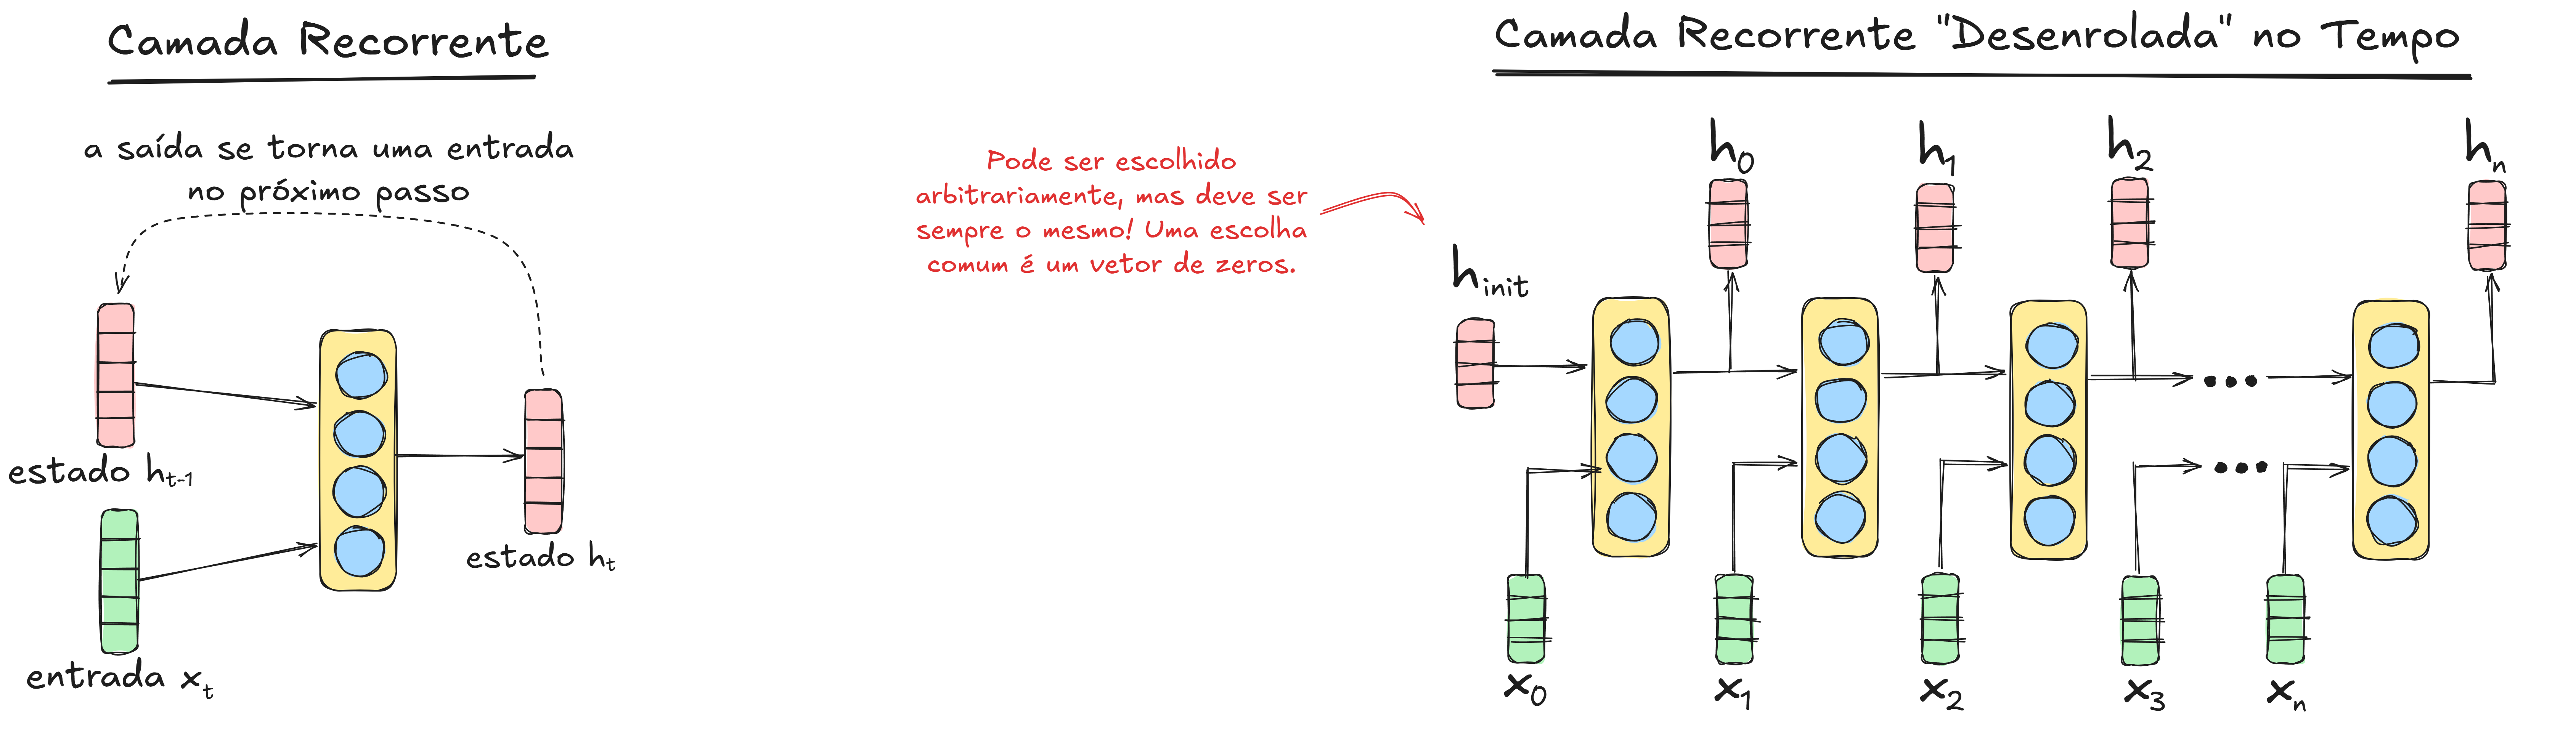


### Formulação Matemática

Matematicamente, o estado de uma RNN, $h_t$, dada uma entrada $x_t$ pode ser calculado como:

$$
h_t = \sigma (W [h_{t-1}, x_t] + b)
$$

onde:

- $\sigma$: função de ativação não-linear (e.g., $\tanh$)
- $W$: matriz de pesos
- $b$: bias
- A operação $[h_{t-1}, x_t]$ representa a concatenação dos itens.

O estado da RNN pode ser usado como entrada para outras camadas para classificação, por exemplo.


**Inicialização**: O estado inicial $h_{init}$ (equivalente a um "$h_{-1}$") pode ser escolhido arbitrariamente, mas deve ser sempre o mesmo. Uma escolha comum é um array de zeros.

**Critério de Parada**: Dependendo da tarefa, o número de saídas pode ser diferente do número de entradas. Nestes casos, é necessário definir critérios de parada para o gerador e escolhas comuns são:
- Fim da entrada
- Número máximo de passos
- Retorno de um token de finalização

## Implementação com Pytorch

A célula abaixo demonstra como definir uma RNN usando Pytorch.

In [ ]:
import numpy as np
import torch

class Rnn(torch.nn.Module):
    def __init__(self, input_size, num_neurons):
        # o construtor recebe como entrada o tamanho da
        # entrada e o número de neurônios no estado.
        super().__init__()
        self._n = num_neurons

        # camada linear para calcular as saídas a partir das entradas
        self._linear = torch.nn.Linear(input_size + num_neurons, num_neurons)

        # função de ativação
        self._act = torch.nn.Tanh()

    def initial_state(self):
        # retorna o estado inicial
        return torch.zeros(1, self._n, dtype=torch.float32)

    def forward(self, x, h):
        # concatena a entrada e o estado anterior
        ins = torch.concat([x, h], dim=-1)

        # passa x_t e h_{t-1} pela camada recorrente e atualiza o estado
        h = self._act(self._linear(ins))

        # retorna o estado atual
        return h


rnn = Rnn(input_size=3, num_neurons=5)
rnn

Rnn(
  (_linear): Linear(in_features=8, out_features=5, bias=True)
  (_act): Tanh()
)

A célula abaixo demonstra como a rede poderia ser utilizada para fazer inferência em 4 sequências, cada uma com 6 itens.

In [ ]:

n_sequences = 4
n_steps = 6

# para cada sequencia
for seq_id in range(n_sequences):

    # reiniciamos o estado da RNN para o valor padrao
    h = rnn.initial_state()

    # para cada passo na sequencia
    for _ in range(n_steps):

        # entrada aleatoria de exemplo
        x_i = torch.tensor(np.random.uniform(-1, 1, size=(1, 3)).astype(np.float32))

        # passamos a entrada pela rede e obtemos o estado atualizado
        h = rnn(x_i, h)

    # mostra o ultimo estado
    print(f"estado final da seq {seq_id}: {h}")


estado final da seq 0: tensor([[-0.1159,  0.4552,  0.0595, -0.1009, -0.2561]],
       grad_fn=<TanhBackward0>)
estado final da seq 1: tensor([[-0.0550,  0.4793,  0.2579,  0.0119, -0.1175]],
       grad_fn=<TanhBackward0>)
estado final da seq 2: tensor([[0.1297, 0.4814, 0.1598, 0.2375, 0.1601]], grad_fn=<TanhBackward0>)
estado final da seq 3: tensor([[ 0.2378,  0.2564, -0.1925,  0.1207,  0.0727]],
       grad_fn=<TanhBackward0>)


## Treinamento de RNNs com Backpropagation through Time (BPTT)


Como ilustrado nas figuras abaixo, dependendo do tipo de tarefa podemos utilizar todos os estados da RNN ou apenas o último. Em tarefas de classificação de sequências (e.g., análise de sentimentos), usamos o estado final como entrada para uma rede de classificação como uma rede Multilayer Perpceptron (MLP). Em tarefas many-to-many pareado, a cada instante o estado é usado como entrada para o classificador.

O treinamento é realizado fazendo *backpropagation*, da mesma forma que faríamos com uma rede MLP de várias camadas, exceto que aqui temos a mesma camada sendo "replicada" ao longo do tempo. Por isto, esta versão do algoritmo é chamada de **Backpropagation Through Time (BPTT)** (em português, retropropagação através do tempo). Desenrolamos a rede em todos os passos de tempo e computamos as saídas. Anotações (saídas esperadas) são comparadas com as saídas geradas pela RNN e computa-se o valor da função de perda para cada saída. A seguir, aplica-se retropropagação do erro. Como cada passo depende dos anteriores e todos eles compartilham os mesmos pesos, o gradiente total de um peso é a soma das contribuições de cada instante.

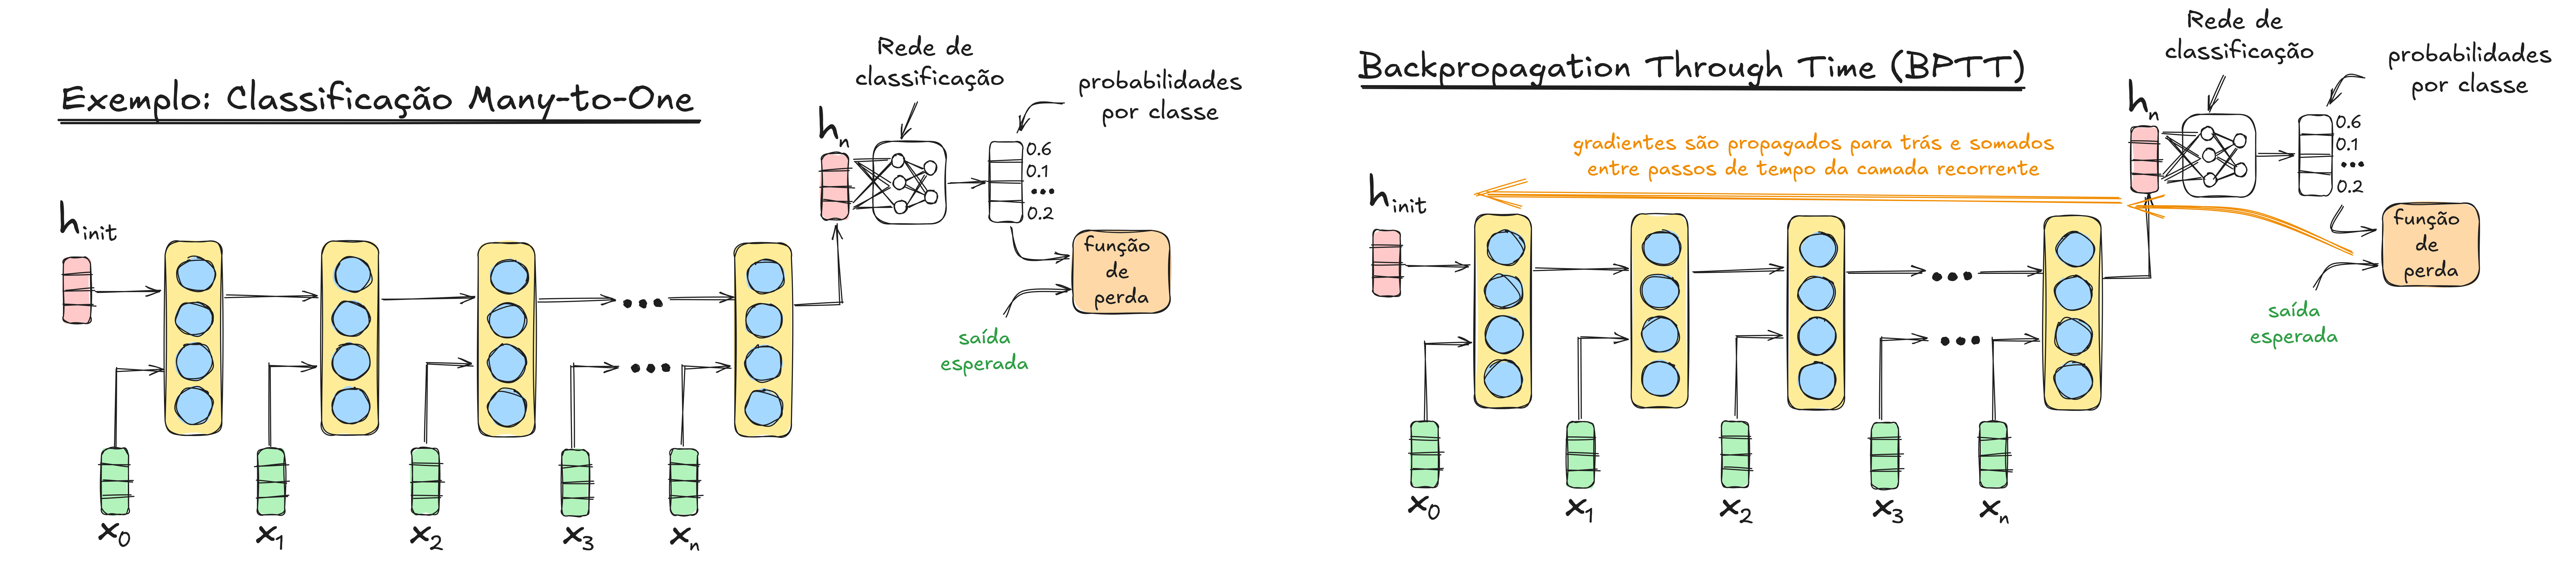

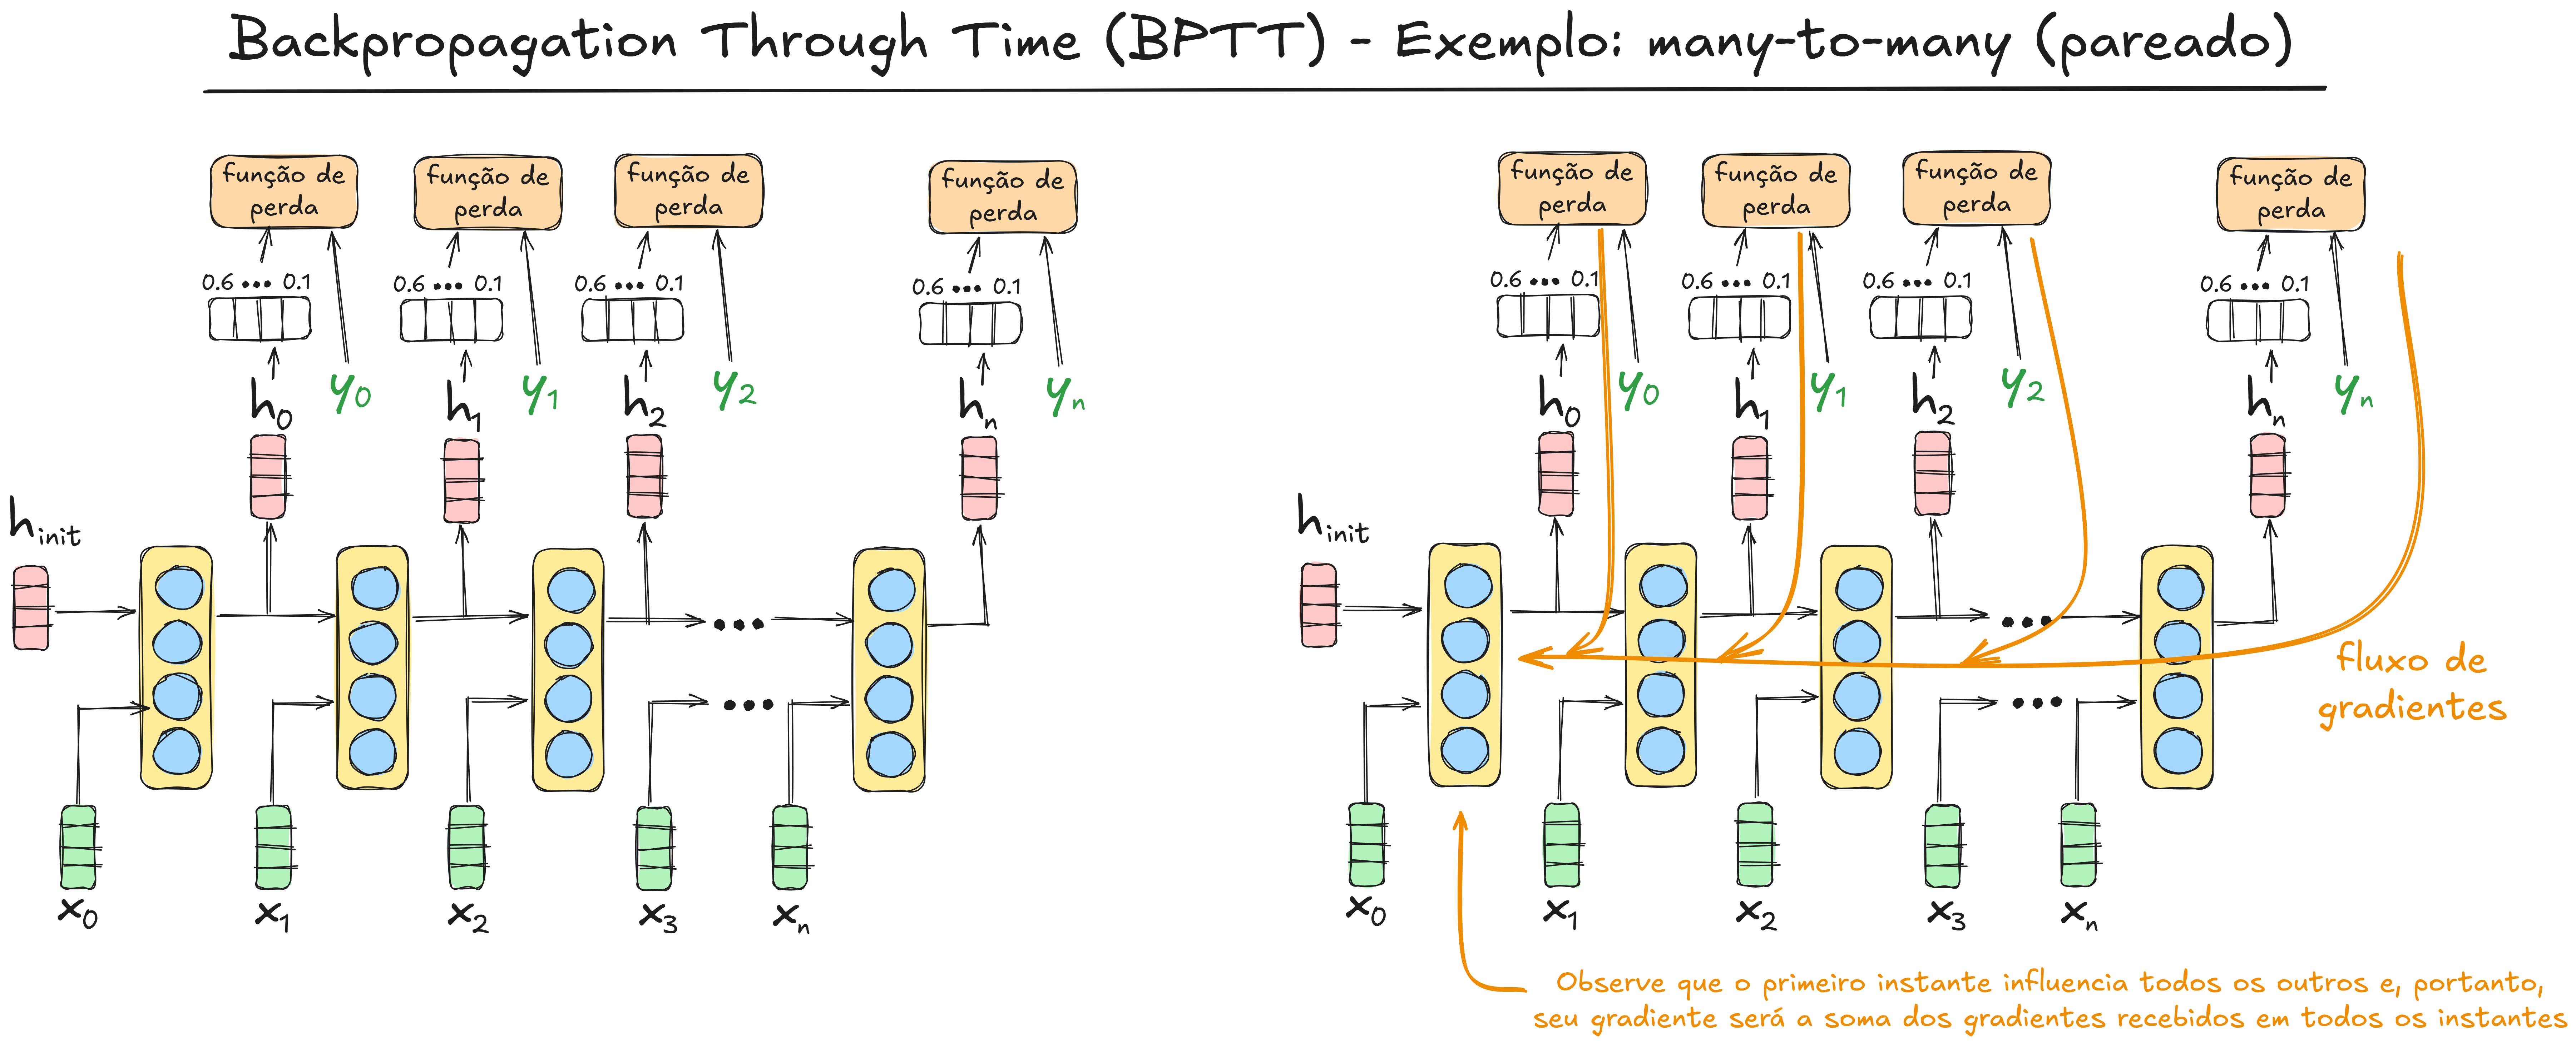

### Detalhes de Implementação: Padding, Packing e Masking

**Padding.** Suponha que queremos treinar um batch de sequências com comprimentos diferentes. Principalmente para garantir processamento eficiente em GPUs, muitos frameworks demandam que as amostras em um batch tenham o mesmo tamanho. Para isso, aplicamos **padding**: preenchemos sequências mais curtas com um token especial (por exemplo, índice 0) até o tamanho máximo do lote.

**Truncation**: Outra operação que pode ser utilizada para uniformizar o tamanho das sequências é o truncamento que consiste em cortar as sequências em um tamanho máximo. Esta operação pode resultar em amostras incompletas.

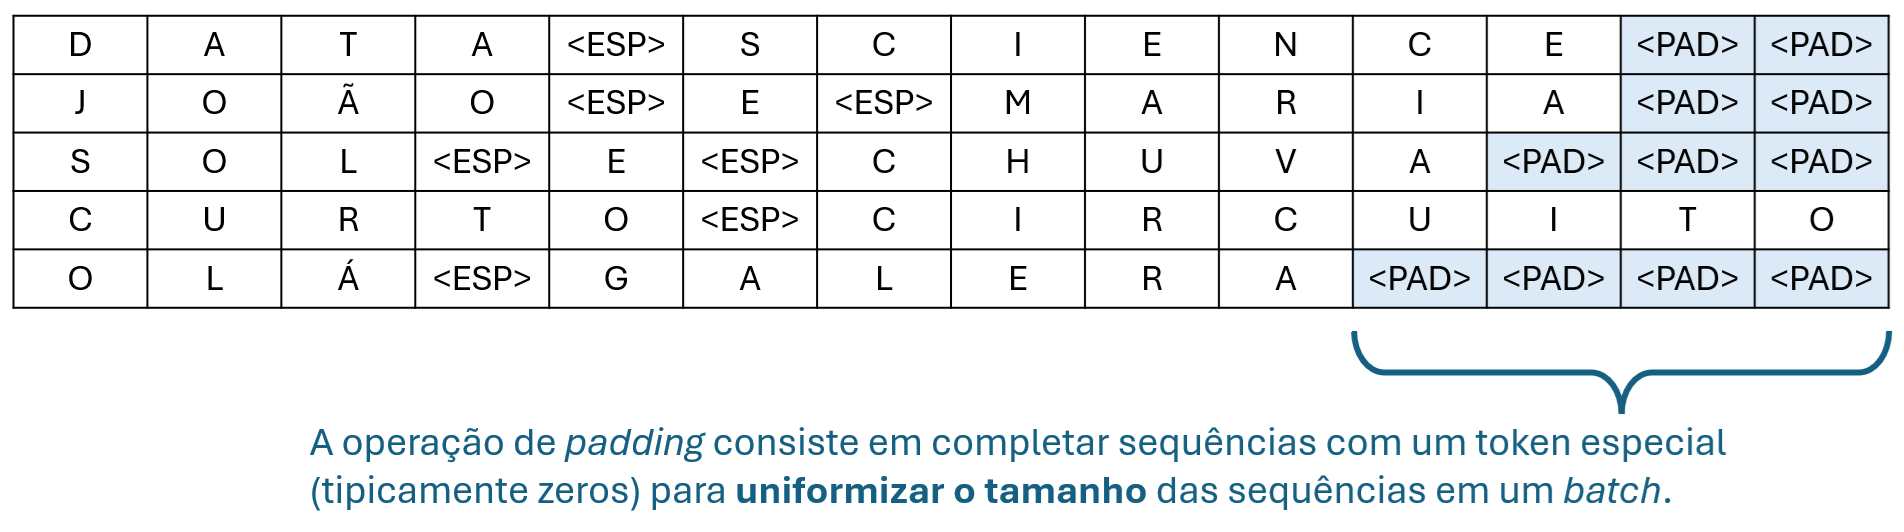

In [ ]:
from torch.nn.utils.rnn import pad_sequence

# Sequências de comprimentos diferentes (valores representam índices de palavras)
seqs = [
    torch.tensor([1, 2, 3]),
    torch.tensor([4]),
    torch.tensor([7, 5, 1, 0, 7]),
    torch.tensor([6, 8, 9, 8]),
]
padded = pad_sequence(seqs, batch_first=True, padding_value=0)

print("Padded:\n", padded)


Padded:
 tensor([[1, 2, 3, 0, 0],
        [4, 0, 0, 0, 0],
        [7, 5, 1, 0, 7],
        [6, 8, 9, 8, 0]])


**Packing.** A técnica de padding introduz desperdício de computação dado que várias posições podem passar pela RNN sem necessidade. Para evitar este desperdício, a biblioteca pytorch armazena as sequências em uma estrutura dita "empacotada" (*packed*). Esta estrutura armazena o tamanho das sequências. Usando estas informações, as posições relativas ao padding não são computadas e não são utilizadas no cálculo de gradientes.

In [ ]:

from torch.nn.utils.rnn import pack_padded_sequence

# Calcula o tamanho das sequencias
sequence_lengths = torch.tensor([len(seq) for seq in seqs])

# Faz o packing das sequencias
packed_sequences = pack_padded_sequence(padded, sequence_lengths, batch_first=True, enforce_sorted=False)
packed_sequences


PackedSequence(data=tensor([7, 6, 1, 4, 5, 8, 2, 1, 9, 3, 0, 8, 7]), batch_sizes=tensor([4, 3, 3, 2, 1]), sorted_indices=tensor([2, 3, 0, 1]), unsorted_indices=tensor([2, 3, 0, 1]))

**Masking.** Ao calcular a perda, é necessário descartar as saídas correspondentes às entradas de padding para que elas não influenciam o valor da função de perda. Uma forma de alcançar este objetivo é multiplicar os valores da perda a cada instante por uma máscara binária. Os valores de perda relativos às saídas válidas são multiplicadas por 1, enquanto aqueles relativas às saídas inválidas são multiplicadas por 0.

---

No próximo notebook, vamos conhecer limitações de RNNs e um tipo especial de rede neural recorrente chamado redes Long Short-Term Memory (LSTM) que supera estas limitações.
